In [1]:
#nltk.download('punkt')
#nltk.download('punkt_tab')
#nltk.download('stopwords')
#nltk.download('wordnet')


from collections import Counter
import matplotlib.pyplot as plt
import numpy as np
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize
import pandas as pd
import re
import seaborn as sns
from sklearn.compose import ColumnTransformer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import LabelEncoder, StandardScaler
import string

In [2]:
# Load the dataset from Kaggle
df = pd.read_csv('/Users/luzejames/Documents/Python/Capstone Project/combined_data.csv')


In [3]:
# Explore the file
df.head()

,label,text
0,1,ounce feather bowl hummingbird opec moment ala...
1,1,wulvob get your medircations online qnb ikud v...
2,0,computer connection from cnn com wednesday es...
3,1,university degree obtain a prosperous future m...
4,0,thanks for all your answers guys i know i shou...


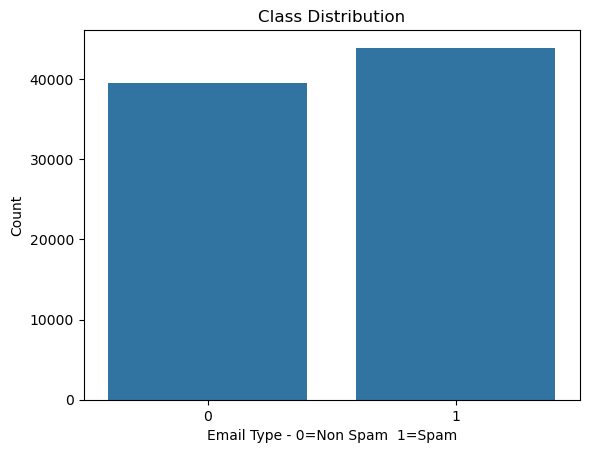

In [4]:
sns.countplot(x='label', data=df)
plt.title("Class Distribution")
plt.xlabel("Email Type - 0=Non Spam  1=Spam")
plt.ylabel("Count")
plt.show()

In [5]:
# Explore nulls
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 83448 entries, 0 to 83447
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   label   83448 non-null  int64 
 1   text    83448 non-null  object
dtypes: int64(1), object(1)
memory usage: 1.3+ MB


In [6]:
# Get English stop words and instantiate WordNetLemmatizer

stop_words = set(stopwords.words('english'))
lemmatizer = WordNetLemmatizer()

# Function to convert text to lowercase, remove punctuation marks, remove all digits,
# tokenize the text into individual words, remove stop words and reduce words to their base form. 
def clean_text(text):    
    text = text.lower()
    text = text.translate(str.maketrans('', '', string.punctuation))
    text = re.sub(r'\d+', '', text)
    tokens = word_tokenize(text)
    tokens = [lemmatizer.lemmatize(word) for word in tokens if word not in stop_words]
    return ' '.join(tokens)

# Function to extract the following features from the text: Average of the word count per row, Indicator about the text having links,
# Indicator to tell if there are special words that indicate spam, 
# Counts of the following: Characters and words, Punctuation marks, Number of digits, and Number of stopwords.

def extract_features(text):
    words = word_tokenize(text)
    return {
        'avg_word_length': np.mean([len(w) for w in words]) if words else 0,
        'has_links': int(bool(re.search(r"http[s]?://|www\.", text.lower()))),
        'has_special_offer_words': int(any(word in text.lower() for word in ['free', 'win', 'cash', 'credit', 'prize', 'offer', 'urgent'])),
        'char_count': len(text),
        'word_count': len(words),
        'num_punctuation': sum(1 for c in text if c in string.punctuation),
        'num_digits': sum(1 for c in text if c.isdigit()),
        'num_stopwords': sum(1 for w in words if w.lower() in stop_words)
    }

In [7]:
# Apply extract_features to DataFrame 
engineered_df = df['text'].apply(lambda x: pd.Series(extract_features(x)))

# Add Engineered Features to the original DataFrame
df = pd.concat([df, engineered_df], axis=1)
df.head()

,label,text,avg_word_length,has_links,has_special_offer_words,char_count,word_count,num_punctuation,num_digits,num_stopwords
0,1,ounce feather bowl hummingbird opec moment ala...,6.450000,0.0,0.0,148.0,20.0,0.0,0.0,0.0
1,1,wulvob get your medircations online qnb ikud v...,6.788462,0.0,0.0,808.0,104.0,1.0,0.0,25.0
2,0,computer connection from cnn com wednesday es...,5.612426,0.0,1.0,2235.0,338.0,1.0,0.0,62.0
3,1,university degree obtain a prosperous future m...,6.789474,0.0,1.0,592.0,76.0,0.0,0.0,21.0
4,0,thanks for all your answers guys i know i shou...,5.112108,0.0,0.0,1362.0,223.0,32.0,0.0,50.0


In [8]:
# Apply the function clean_text to the text column, add a new column with the clean data 
df['cleaned_text'] = df['text'].apply(clean_text)


In [9]:
df.head()

,label,text,avg_word_length,has_links,has_special_offer_words,char_count,word_count,num_punctuation,num_digits,num_stopwords,cleaned_text
0,1,ounce feather bowl hummingbird opec moment ala...,6.450000,0.0,0.0,148.0,20.0,0.0,0.0,0.0,ounce feather bowl hummingbird opec moment ala...
1,1,wulvob get your medircations online qnb ikud v...,6.788462,0.0,0.0,808.0,104.0,1.0,0.0,25.0,wulvob get medircations online qnb ikud viagra...
2,0,computer connection from cnn com wednesday es...,5.612426,0.0,1.0,2235.0,338.0,1.0,0.0,62.0,computer connection cnn com wednesday escapenu...
3,1,university degree obtain a prosperous future m...,6.789474,0.0,1.0,592.0,76.0,0.0,0.0,21.0,university degree obtain prosperous future mon...
4,0,thanks for all your answers guys i know i shou...,5.112108,0.0,0.0,1362.0,223.0,32.0,0.0,50.0,thanks answer guy know checked rsync manual wo...


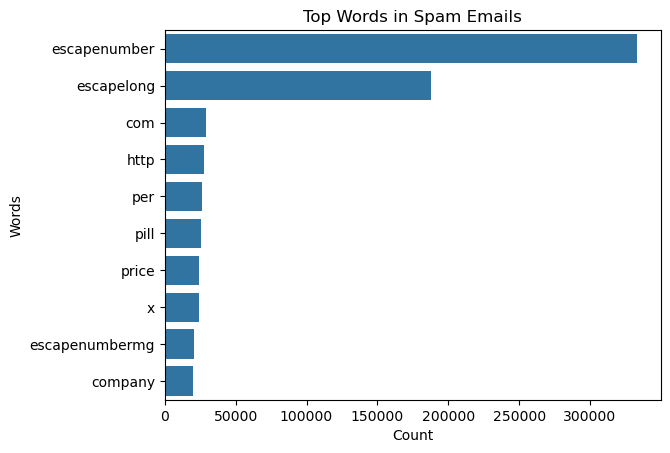

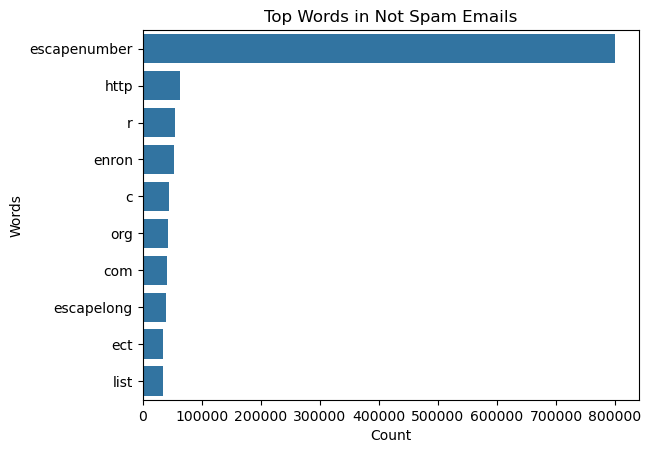

In [10]:
# Count and plot top words 
def get_top_words(texts, n=10):
    all_words = ' '.join(texts).split()
    return Counter(all_words).most_common(n)

# Get top words for each class
spam_words = get_top_words(df[df['label'] == 1]['cleaned_text'], n=10)
not_spam_words = get_top_words(df[df['label'] == 0]['cleaned_text'], n=10)

def plot_top_words(word_counts, title):
    if not word_counts:
        print(f"No words found for: {title}")
        return
    words, counts = zip(*word_counts)
    sns.barplot(x=counts, y=words)
    plt.title(title)
    plt.xlabel("Count")
    plt.ylabel("Words")
    plt.show()

# Generate plots
plot_top_words(spam_words, "Top Words in Spam Emails")
plot_top_words(not_spam_words, "Top Words in Not Spam Emails")


In [11]:
# Define features and target column
X = df.drop(columns=['label'])
y = df['label']

# Train/test split
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=0.2, random_state=42)



In [12]:
# Preprocessing 
preprocessor = ColumnTransformer(transformers=[
    ('tfidf', TfidfVectorizer(max_features=1000), 'cleaned_text'),
    ('scale', StandardScaler(), engineered_df.columns.tolist())
])

In [13]:
# Create the Pipeline
pipeline = Pipeline([
    ('features', preprocessor),
    ('clf', LogisticRegression(max_iter=1000, class_weight='balanced'))
])

In [14]:
# Train and Predict
pipeline.fit(X_train, y_train)

# Predict
y_pred = pipeline.predict(X_test)

In [15]:
# Evaluate
print(classification_report(y_test, y_pred, zero_division=0))

              precision    recall  f1-score   support

           0       0.97      0.96      0.97      7908
           1       0.97      0.97      0.97      8782

    accuracy                           0.97     16690
   macro avg       0.97      0.97      0.97     16690
weighted avg       0.97      0.97      0.97     16690



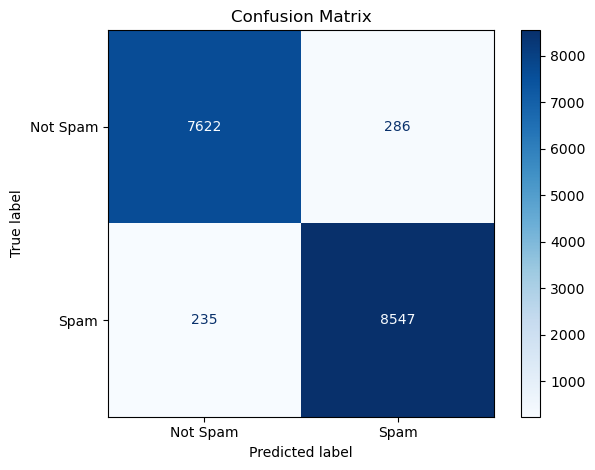

In [16]:
ConfusionMatrixDisplay.from_predictions(y_test, y_pred, display_labels=['Not Spam', 'Spam'], cmap='Blues')
plt.title("Confusion Matrix")
plt.tight_layout()
plt.show()